# IV - 0D computations H2

In [140]:
#!cti2yaml h2_williams_12.cti

In [141]:
import sys
import numpy as np
import cantera as ct
import matplotlib.pyplot as plt#
from matplotlib import *
import csv

Temp=       1200.0
T_str=     '1200'
n_points =  80500    #iterations    40000,50000,80000,300000
Dt = 2e-9            #2e-7

# Create a Cantera Solution object
gas = ct.Solution('h2_williams_12.yaml', 'h2_williams_12')
gas.TPX = Temp, ct.one_atm, {'H2': 1, 'O2': 1, 'H2O': 2}
Ini_Temp=gas.T
# Get properties
density = gas.density
viscosity = gas.viscosity
thermal_conductivity = gas.thermal_conductivity
kinematic_viscosity = viscosity / density  # m²/s
cp = gas.cp

species_names = gas.species_names
molar_masses = gas.molecular_weights/1000  # Molar masses in kg/mol
diff_coeffs = gas.mix_diff_coeffs  # m²/s
mass_fractions = gas.Y
mol_frac = gas.X

print(gas())
print("-------------------------------------------------------")
print(f"Density (rho_0):\t {density:.4e} kg/m³")
print(f"Kine Visc (nu_0):\t {kinematic_viscosity:.4e} m²/s")
print(f"cp: \t\t\t{cp:.2f} ")
print(f"Therm Cond:(lambda)\t {thermal_conductivity:.4e} W/m/K\n\n")

for i, specie in enumerate(species_names):
    print(f"Species: {specie}")
    print(f"Molar Mass: {molar_masses[i]:.4f}")  # Print molar mass in SI units
    print(f"Mass Fraction: {mass_fractions[i]:.6f}")
    print(f"Mole Fraction: {mol_frac[i]:.6f}")
    print(f"Mix Diffusion Coefficient: {diff_coeffs[i]:.4e}")
    print("")



  h2_williams_12:

       temperature   1200 K
          pressure   1.0132e+05 Pa
           density   0.17783 kg/m^3
  mean mol. weight   17.511 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy       -5.1116e+06       -8.9509e+07  J
   internal energy       -5.6814e+06       -9.9487e+07  J
           entropy             13383        2.3435e+05  J/K
    Gibbs function       -2.1171e+07       -3.7073e+08  J
 heat capacity c_p            2204.4             38601  J/K
 heat capacity c_v            1729.6             30287  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                H2          0.028782              0.25           -19.364
                O2           0.45683              0.25           -28.473
               H2O           0.51439               0.5        

In [142]:
print("#name     Molar Mass")
for i in range(len(species_names)):
    print(f"{species_names[i]:<6} {molar_masses[i]:.6f}")    
    
print("\n\n#    Initial mass fractions (FLOW)")
for i in range(len(species_names)):
    print(f"{species_names[i]:<6} {mass_fractions[i]:.6f}", end="    " if i % 2 == 0 else "\n")

print("\n#    Initial diffusion coefficients (FLOW)")
for i in range(len(species_names)):
    print(f"{species_names[i]:<6} {diff_coeffs[i]:.4e}", end="    " if i % 2 == 0 else "\n")


#name     Molar Mass
H2     0.002016
H      0.001008
O2     0.031998
OH     0.017007
O      0.015999
H2O    0.018015
HO2    0.033006
H2O2   0.034014
N2     0.028014


#    Initial mass fractions (FLOW)
H2     0.028782    H      0.000000
O2     0.456827    OH     0.000000
O      0.000000    H2O    0.514391
HO2    0.000000    H2O2   0.000000
N2     0.000000    
#    Initial diffusion coefficients (FLOW)
H2     1.1903e-03    H      1.6839e-03
O2     2.6820e-04    OH     4.7671e-04
O      4.8442e-04    H2O    4.3485e-04
HO2    3.1617e-04    H2O2   3.1441e-04
N2     3.1245e-04    

In [143]:
gas.n_species
gas.n_reactions
#gas.species_names


12

In [144]:
# Reactor and environment
r = ct.IdealGasReactor(gas)             ##r = ct.Reactor(gas)
env = ct.Reservoir(gas)                 ##sim = ct.ReactorNet([r])

# Wall
w = ct.Wall(r, env)
w.expansion_rate_coeff = 1.0e6  # set expansion parameter. dV/dt = KA(P_1 - P_2)
w.area = 1.0

# Prepare the simulation with a ReactorNet object
sim = ct.ReactorNet([r])
time = 0
HR = []
temperature = []
mfrac = []
auto_ignitions = []
species_names = ['H2', 'H', 'O2', 'OH', 'O', 'H2O', 'HO2', 'H2O2', 'N2']
times = np.zeros(n_points)
data = np.zeros((n_points, len(species_names) + 3))  # +1 for temperature
header = 'Iteration,Time (s),Temperature,' + ','.join(species_names)

#print(('%10s %10s %10s %14s' % ('t [s]', 'T [K]', 'vol [m3]', 'u [J/kg]')))
for n in range(n_points):
    time += Dt
    sim.advance(time)
    times[n] = time  # time in s
    data[n, 0] = n + 1  # iteration number
    data[n, 1] = time  # time in s
    data[n, 2] = r.T  # set the temperature in the third column
    data[n, 3:] = r.thermo[species_names].X  # set the molar fractions in the remaining columns
    temperature.append(r.T)
    mfrac.append(r.thermo.Y)
    HR.append(- np.dot(gas.net_production_rates, gas.partial_molar_enthalpies)) #Calculates the heat release rate using the net production rates of species and their partial molar enthalpies.
  
data_with_iteration = np.column_stack((data[:, :2], data[:, 2:]))   
np.savetxt('Results/CANTERA_H2_species_molar_fractions'+T_str+'.csv', data_with_iteration, delimiter=',', header=header, comments='')

In [145]:
gas()


  h2_williams_12:

       temperature   2477.5 K
          pressure   1.0133e+05 Pa
           density   0.096837 kg/m^3
  mean mol. weight   19.687 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy       -5.1116e+06       -1.0063e+08  J
   internal energy       -6.1579e+06       -1.2123e+08  J
           entropy             14197        2.7951e+05  J/K
    Gibbs function       -4.0286e+07       -7.9312e+08  J
 heat capacity c_p            2618.6             51553  J/K
 heat capacity c_v            2196.3             43238  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                H2        0.00095987         0.0093735           -24.852
                 H        8.9597e-05         0.0017499           -12.657
                O2           0.22004           0.13538     

In [146]:
auto_ignition = times[HR.index(max(HR))] #Finds the ignition time (time of maximum heat release rate) by locating the index in the HR list where the maximum value occurs and then finding the corresponding time from the time list
print('For T = ' + str(Ini_Temp) + ', Autoignition time = ' + str(auto_ignition) + ' s')
# Posterity
FinalTemp = temperature[n_points - 1]
auto_ignitions.append(auto_ignition)

For T = 1200.0, Autoignition time = 5.318199999997827e-05 s


In [147]:
gas()


  h2_williams_12:

       temperature   2477.5 K
          pressure   1.0133e+05 Pa
           density   0.096837 kg/m^3
  mean mol. weight   19.687 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy       -5.1116e+06       -1.0063e+08  J
   internal energy       -6.1579e+06       -1.2123e+08  J
           entropy             14197        2.7951e+05  J/K
    Gibbs function       -4.0286e+07       -7.9312e+08  J
 heat capacity c_p            2618.6             51553  J/K
 heat capacity c_v            2196.3             43238  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                H2        0.00095987         0.0093735           -24.852
                 H        8.9597e-05         0.0017499           -12.657
                O2           0.22004           0.13538     

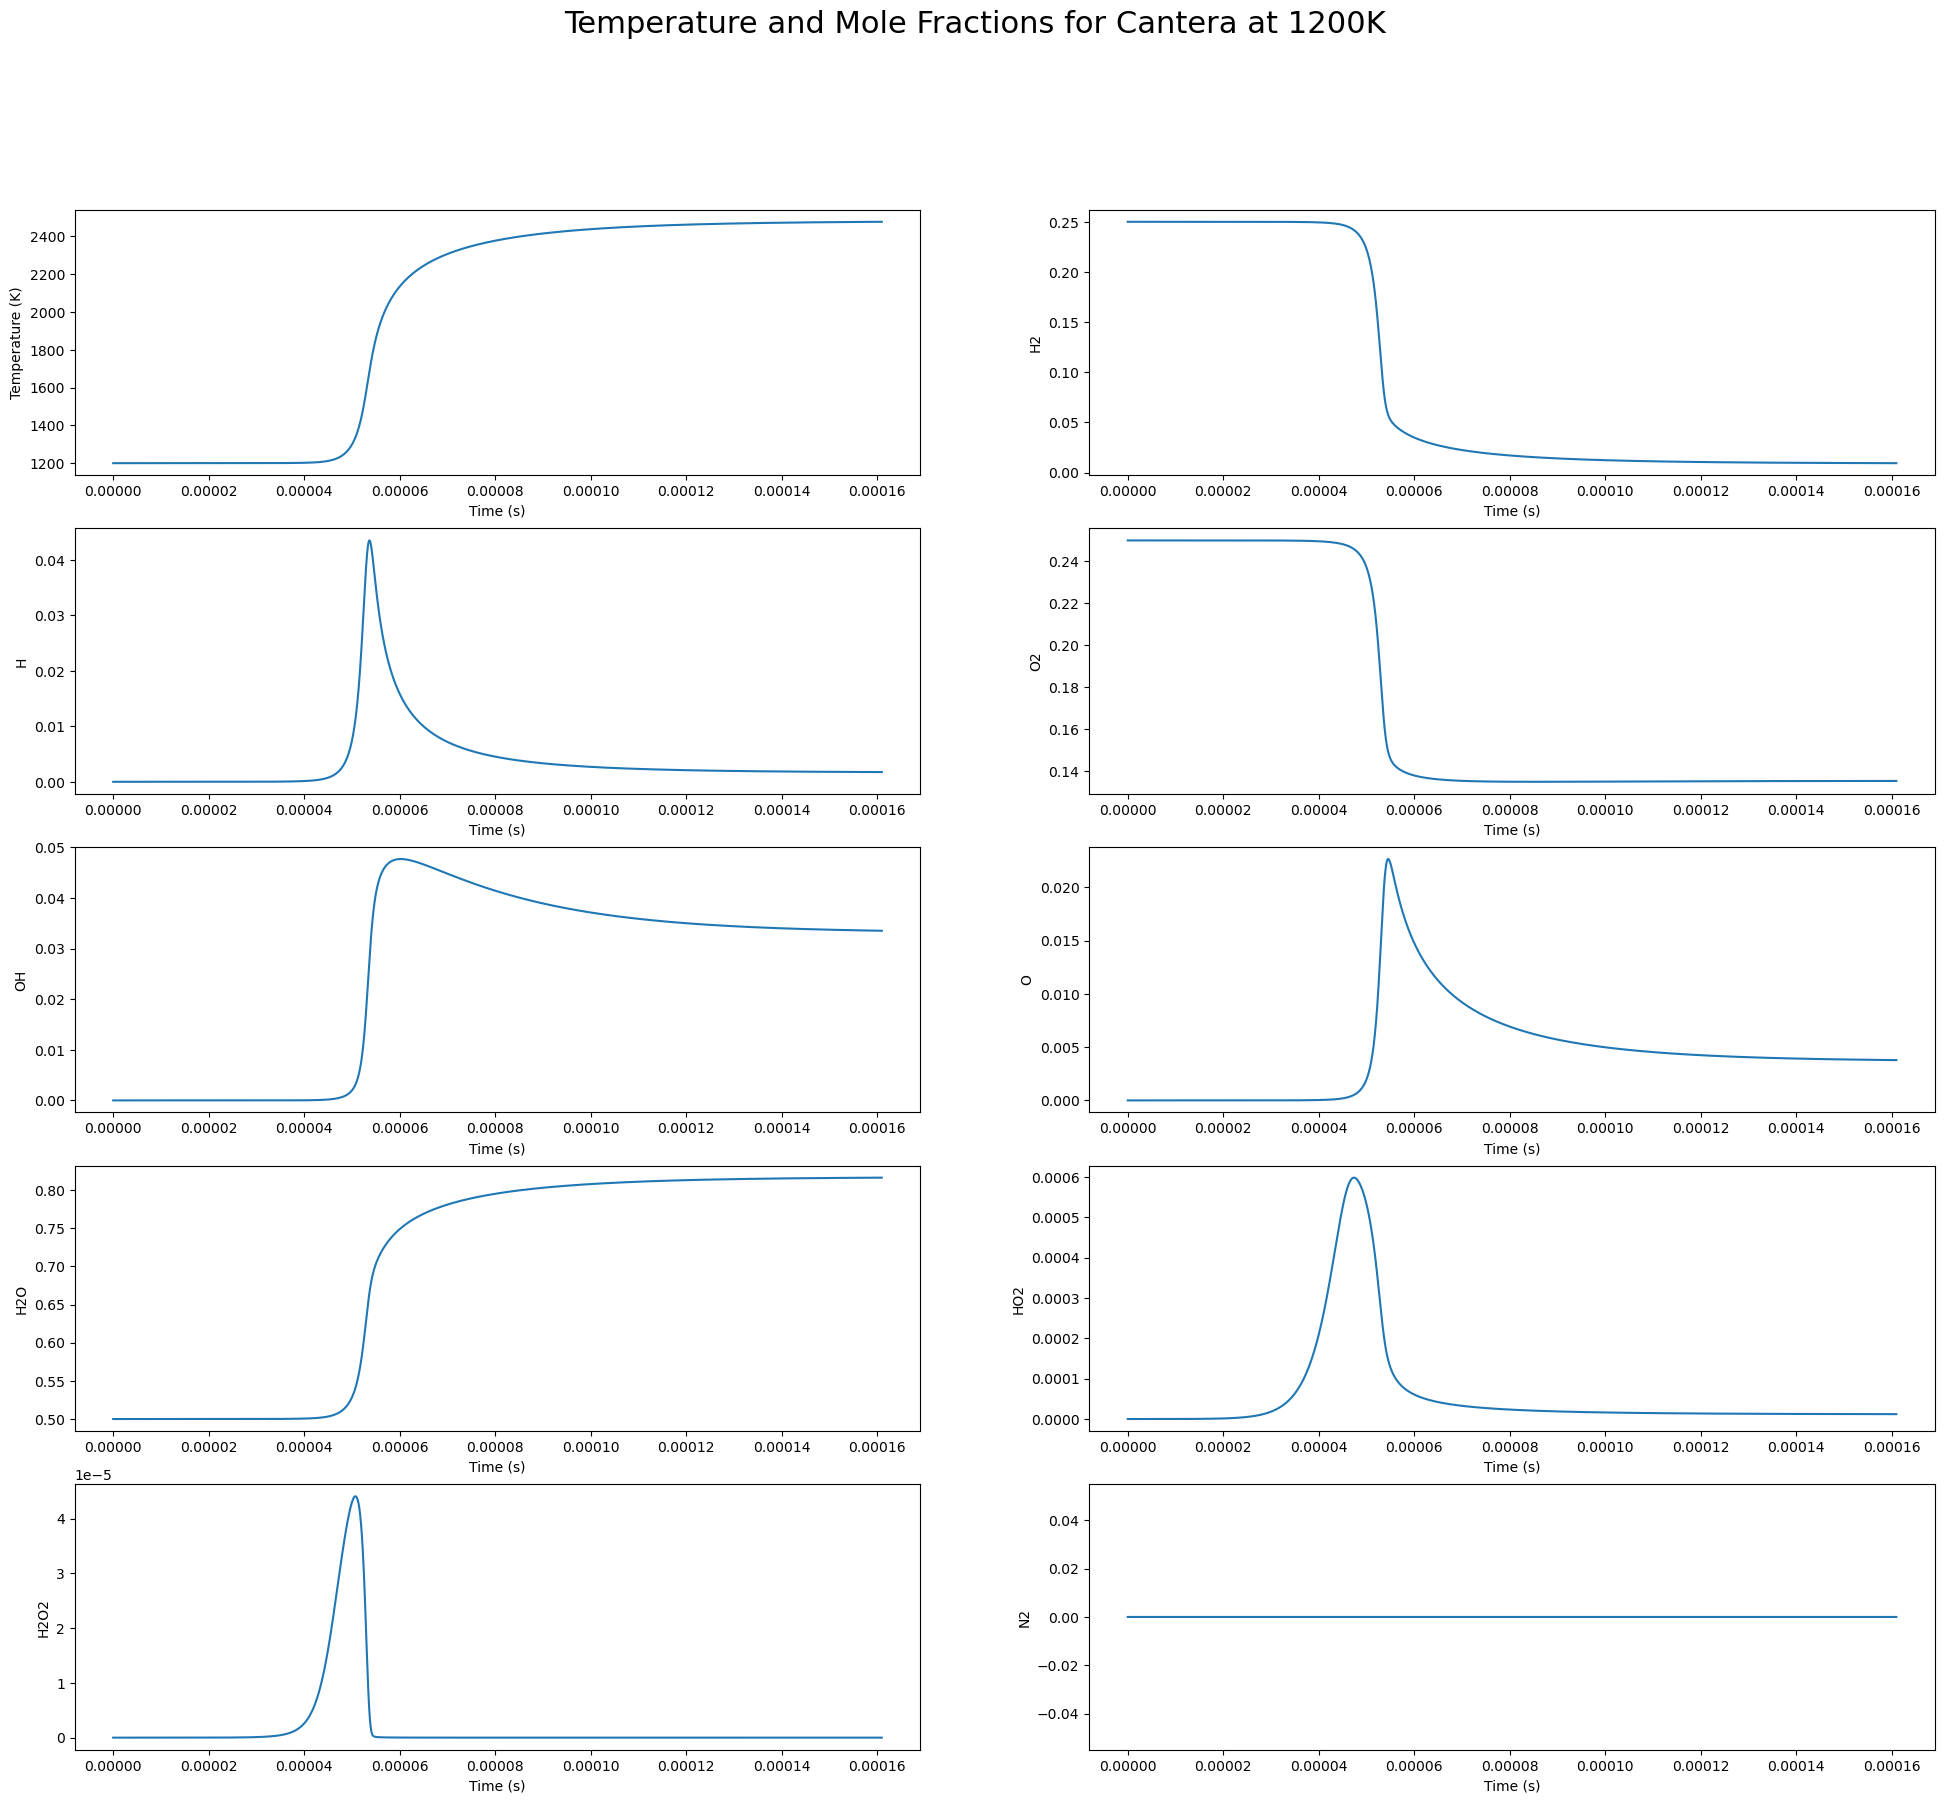

In [148]:
# Define your list of species
species_to_plot = ['Temperature (K)']+species_names

# Create a subplot grid dynamically based on the number of species
num_species = len(species_to_plot)
num_rows = int(np.ceil(num_species / 2))
num_cols = min(2, num_species)

# Set the figure size
plt.figure(figsize=(24, 20))

# Loop through each species and create a subplot
for i, species in enumerate(species_to_plot):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.plot(times, data[:, i + 2])
    plt.xlabel('Time (s)')
    plt.ylabel(species)
    

# Adjust subplot layout
#plt.tight_layout()
plt.suptitle('Temperature and Mole Fractions for Cantera at '+T_str+'K', fontsize=22)
plt.savefig(f'Results/0D-Cantera_H2_{Temp}.png', dpi=300)
# Show the plot
plt.show()